<a href="https://colab.research.google.com/github/priyadarshinivr19/Minors-Degree-Machine-Learning/blob/main/Machine_Learning_Program_2024_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **End-to-End Stock Analysis and Prediction for AAPL with Python**


This project demonstrates a complete workflow for stock price analysis and predictive modeling using Apple Inc. (AAPL) as an example. We will download historical data, engineer technical indicators, perform exploratory data analysis (EDA), preprocess the data, build multiple machine learning models, evaluate their performance, explain the models using feature importance and SHAP, visualize interactive charts, and finally backtest a simple trading strategy. The code is structured for Google Colab compatibility, with necessary installations and inline visualizations.

**1. Setup and Data Collection with yfinance**

First, we install and import the required libraries. We use the yfinance library to fetch 1 year of daily data for AAPL, including Open, High, Low, Close, Adj Close, and Volume. We will obtain a DataFrame indexed by date.

In [11]:
!pip install yfinance pandas pandas_ta matplotlib seaborn plotly mplfinance scikit-learn xgboost shap


In [12]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch 1 year of daily data for AAPL
ticker = "AAPL"
df = yf.download(ticker, period="1y", interval="1d")  # 1 year, daily interval
print("Data shape:", df.shape)
df.head()


[*********************100%***********************]  1 of 1 completed

Data shape: (251, 5)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-05-16,188.956314,190.210459,188.777159,189.583386,52845200
2024-05-17,188.986176,189.921802,188.299385,188.627851,41282900
2024-05-20,190.150726,191.026635,188.130177,188.448695,44361300
2024-05-21,191.454636,191.832856,190.031284,190.200491,42309400
2024-05-22,190.011368,191.922444,189.384311,191.375001,34648500


The data typically includes columns: Open, High, Low, Close, Adj Close, Volume for each trading day. We will use the Close price for most calculations and the Volume for volume-based analysis. Adjusted Close is the close price adjusted for dividends/splits (not strictly needed for short-term technical analysis, so we may drop it later).

**2. Technical Indicator Feature Engineering**

### Feature Engineering Using `pandas_ta`

We engineer a set of popular technical indicators using the `pandas_ta` library (a technical analysis extension for pandas). These features help capture various aspects of price trends, momentum, and volatility.

---

#### Simple Moving Averages (SMA)
- **SMA_20**: 20-day simple moving average to capture short-term trends.  
- **SMA_50**: 50-day simple moving average for medium-term trends.

#### Exponential Moving Averages (EMA)
- **EMA_20**: 20-day exponential moving average (more weight on recent prices).  
- **EMA_50**: 50-day exponential moving average.

#### Relative Strength Index (RSI)
- **RSI_14**: 14-day RSI, a momentum oscillator that identifies overbought/oversold conditions by comparing recent gains vs. losses.

#### Moving Average Convergence Divergence (MACD)
- **MACD Line**: Difference between 12-day EMA and 26-day EMA.  
- **Signal Line**: 9-day EMA of the MACD line.  
- **MACD Histogram**: Difference between MACD line and Signal line.  
- A trend-following momentum indicator to signal trend shifts.

#### Bollinger Bands (20-day, 2 Std Dev)
- **BB_upper**: 20-day SMA + 2 * standard deviation.  
- **BB_middle**: 20-day SMA (center band).  
- **BB_lower**: 20-day SMA − 2 * standard deviation.  
- Used to gauge price volatility and potential reversal points.

#### Average True Range (ATR)
- **ATR_14**: 14-day average of true range, measuring market volatility using high, low, and close prices.

#### Lag Features
- **Prev_Close**: Previous day's closing price.  
- **Prev_Return**: Previous day's percent return.  
- These features provide recent historical context to the model.

#### Binary Target Variable
- **Target**:  
  - `1` if the next day's closing price is higher than today's (price goes up).  
  - `0` otherwise (price stays the same or goes down).  
- This is the target our classification model will learn to predict.


In [13]:
# Calculate 20-day and 50-day Simple Moving Averages on the 'Close' price
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

In [14]:
# Calculate 20-day and 50-day Exponential Moving Averages on the 'Close' price
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

In [15]:
# Calculate daily price change
delta = df['Close'].diff()

# Calculate gains and losses
gain = delta.copy()
loss = delta.copy()
gain[gain < 0] = 0
loss[loss > 0] = 0
loss = -loss  # Make losses positive

# Calculate 14-day average gain and loss
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Calculate RSI
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))


In [16]:
# Calculate EMAs
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()

# MACD line
df['MACD'] = ema_12 - ema_26

# MACD Signal line (9-day EMA of MACD)
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# MACD Histogram (MACD - Signal)
df['MACD_hist'] = df['MACD'] - df['MACD_signal']


In [17]:
print(type(df['Close']))  # Should print: <class 'pandas.core.series.Series'>

# If for some reason it becomes a DataFrame, use this to fix:
close = df['Close']
if isinstance(close, pd.DataFrame):
    close = close.squeeze()  # Convert to Series if it's a single-column DataFrame

# Calculate Bollinger Bands
df['BBM'] = close.rolling(window=20).mean()
rolling_std = close.rolling(window=20).std()

df['BBU'] = df['BBM'] + (2 * rolling_std)
df['BBL'] = df['BBM'] - (2 * rolling_std)


<class 'pandas.core.frame.DataFrame'>


In [18]:
# Calculate True Range (TR)
df['H-L'] = df['High'] - df['Low']
df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

# Calculate 14-day Average True Range (ATR14)
df['ATR14'] = df['TR'].rolling(window=14).mean()

# Drop intermediate columns (optional)
df.drop(['H-L', 'H-PC', 'L-PC', 'TR'], axis=1, inplace=True)

In [19]:
# PrevClose: yesterday's closing price
df['PrevClose'] = close.shift(1)

# PrevReturn: % change from day before yesterday to yesterday
df['PrevReturn'] = df['PrevClose'].pct_change() * 100

# DailyReturn: % change from yesterday to today
df['DailyReturn'] = close.pct_change() * 100

# NextClose: tomorrow's closing price
df['NextClose'] = close.shift(-1)

# Target: 1 if next day's close > today's, else 0
df['Target'] = (df['NextClose'] > close).astype(int)

**3. Exploratory Data Analysis (EDA)**

Before building models, it's important to understand the data and the engineered features. We will create various plots to visualize the stock's behavior and the indicators:

- **Closing Price over Time**:  
  A line chart of AAPL's closing price over the past year, along with 20-day and 50-day moving averages to illustrate trends.

- **Daily Returns**:  
  A time series of daily percentage returns and/or a histogram to see the distribution of returns (often roughly centered around 0 and possibly skewed or heavy-tailed).

- **Volume vs Price**:  
  A dual-axis chart showing price and trading volume, to observe if volume surges correspond to big price moves.

- **Bollinger Bands**:  
  An overlay of Bollinger Bands on the price chart to see how price interacts with the bands. Price tends to oscillate between the bands; touching the upper band can indicate overbought, and the lower band oversold.

- **RSI, MACD, ATR Trends**:  
  Line plots of these indicators over time, to observe how they behave during different market conditions:
  - RSI peaks above 70 or dips below 30 (overbought/oversold)
  - MACD crossovers of its signal line (momentum shifts)
  - ATR rising during volatile periods (high volatility)

- **Correlation Heatmap**:  
  A heatmap of the correlation matrix for the features and target. This helps identify multicollinearity or which indicators have strong relationships with the target.
  - For example, the Close price is expected to be highly correlated with its moving averages.

- **Candlestick Chart**:  
  An interactive candlestick chart of OHLC (open-high-low-close) data with volume. We will demonstrate how to create this using:
  - `Plotly` (for interactive, zoomable charts)

Let's proceed with plotting some of these!

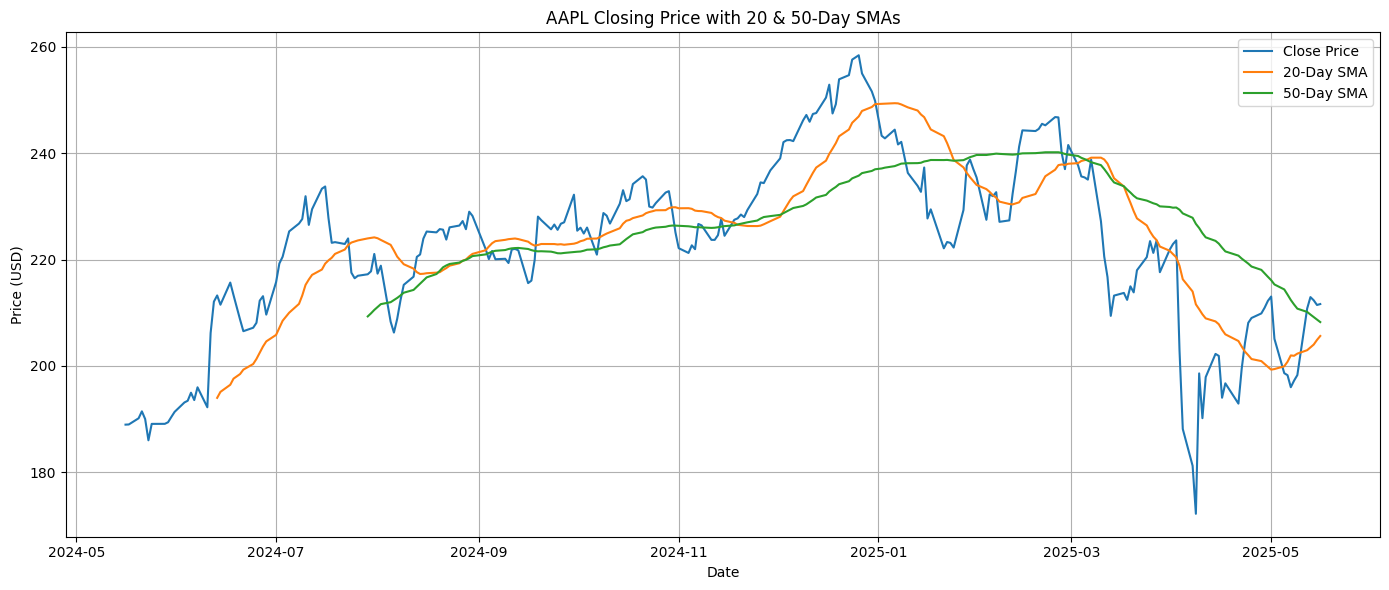

In [20]:
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['SMA_20'], label='20-Day SMA')
plt.plot(df['SMA_50'], label='50-Day SMA')
plt.title("AAPL Closing Price with 20 & 50-Day SMAs")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

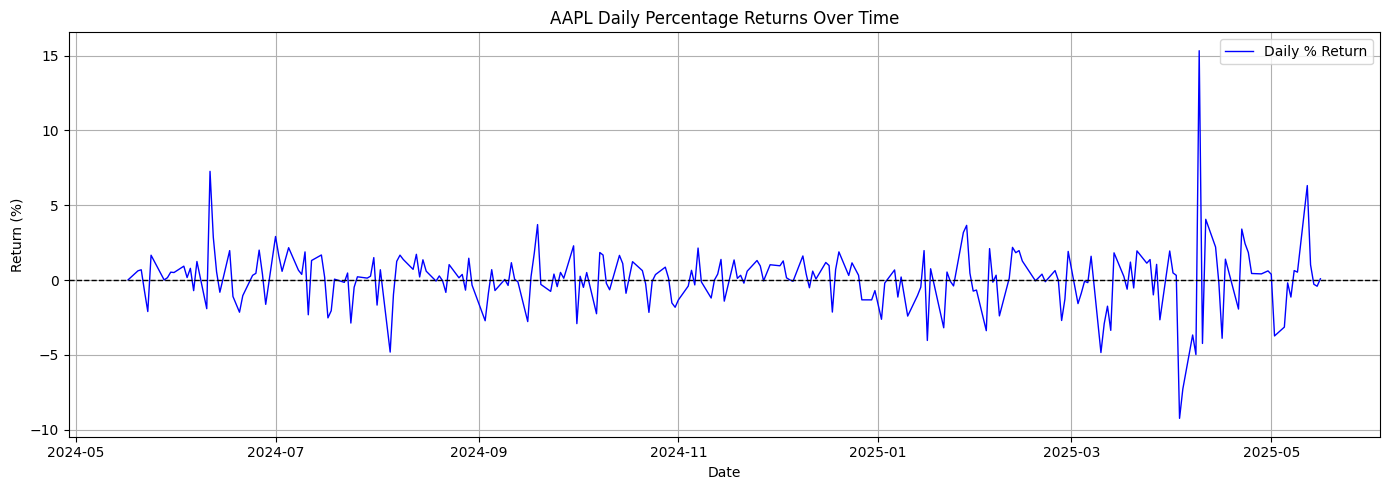

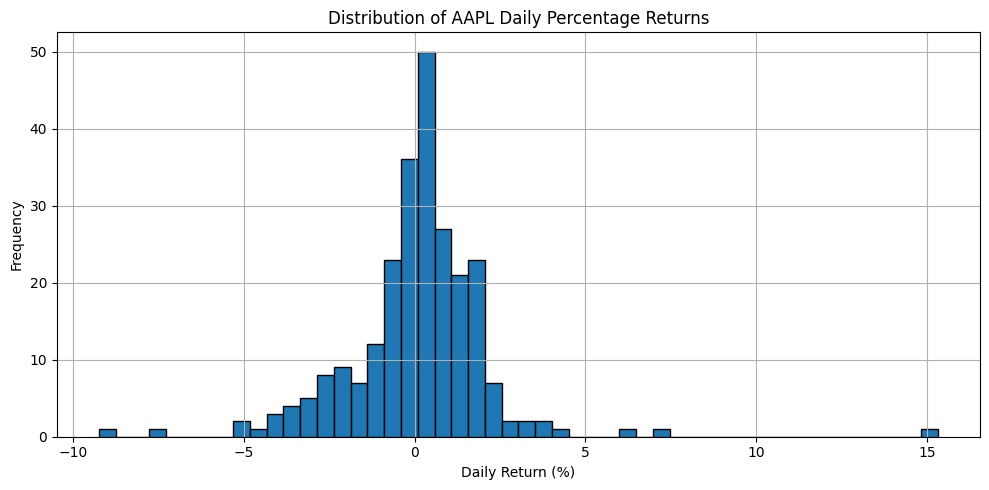

In [21]:
# Plot: Time Series of Daily Returns
plt.figure(figsize=(14, 5))
plt.plot(df['DailyReturn'], label='Daily % Return', color='blue', linewidth=1)
plt.title("AAPL Daily Percentage Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.grid(True)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.legend()
plt.show()

# Plot: Histogram of Daily Returns
plt.figure(figsize=(10, 5))
plt.hist(df['DailyReturn'].dropna(), bins=50, edgecolor='black')
plt.title("Distribution of AAPL Daily Percentage Returns")
plt.xlabel("Daily Return (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

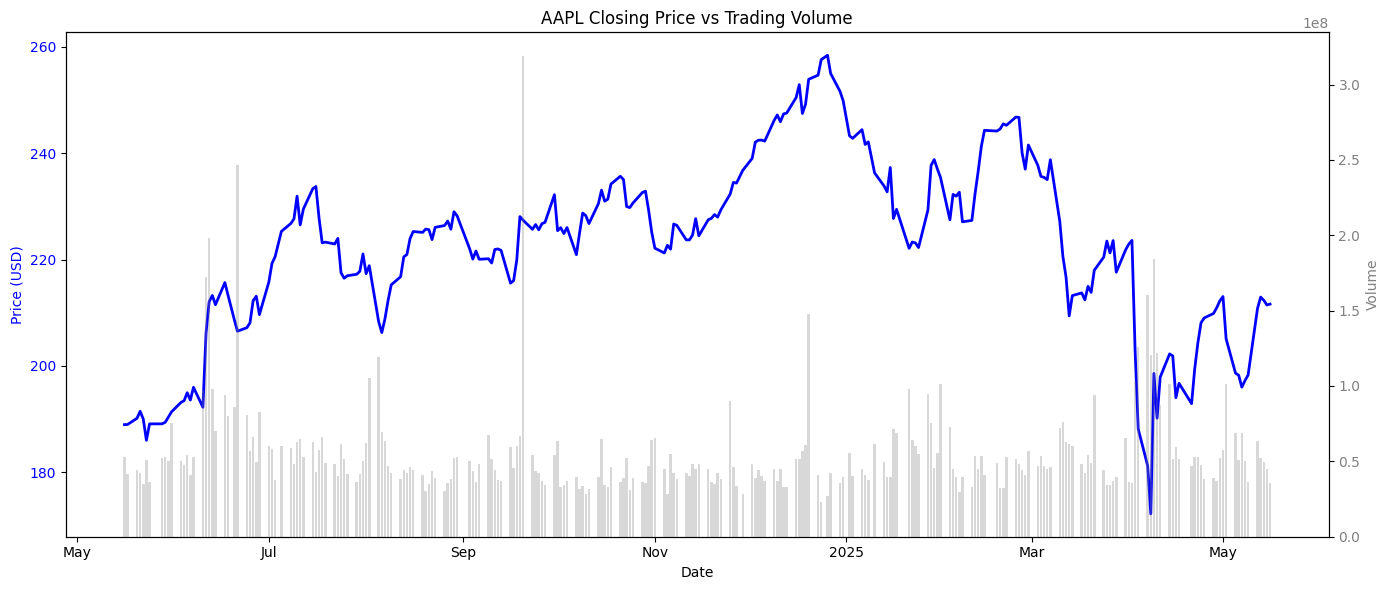

In [23]:
import matplotlib.dates as mdates

# Extract and ensure correct types
dates = pd.to_datetime(df['Date'])
prices = df['Close'].astype(float)
volumes = df['Volume'].squeeze().astype(float)  # flatten in case it's (251,1)

# Convert dates to matplotlib format
date_nums = mdates.date2num(dates)

# Plot setup
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot closing price
ax1.plot(date_nums, prices, color='blue', label='Close Price', linewidth=2)
ax1.set_xlabel("Date")
ax1.set_ylabel("Price (USD)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Format x-axis with date labels
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

# Volume on secondary y-axis
ax2 = ax1.twinx()
ax2.bar(date_nums, volumes, width=0.8, color='gray', alpha=0.3, label='Volume')
ax2.set_ylabel("Volume", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Title and layout
plt.title("AAPL Closing Price vs Trading Volume")
fig.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


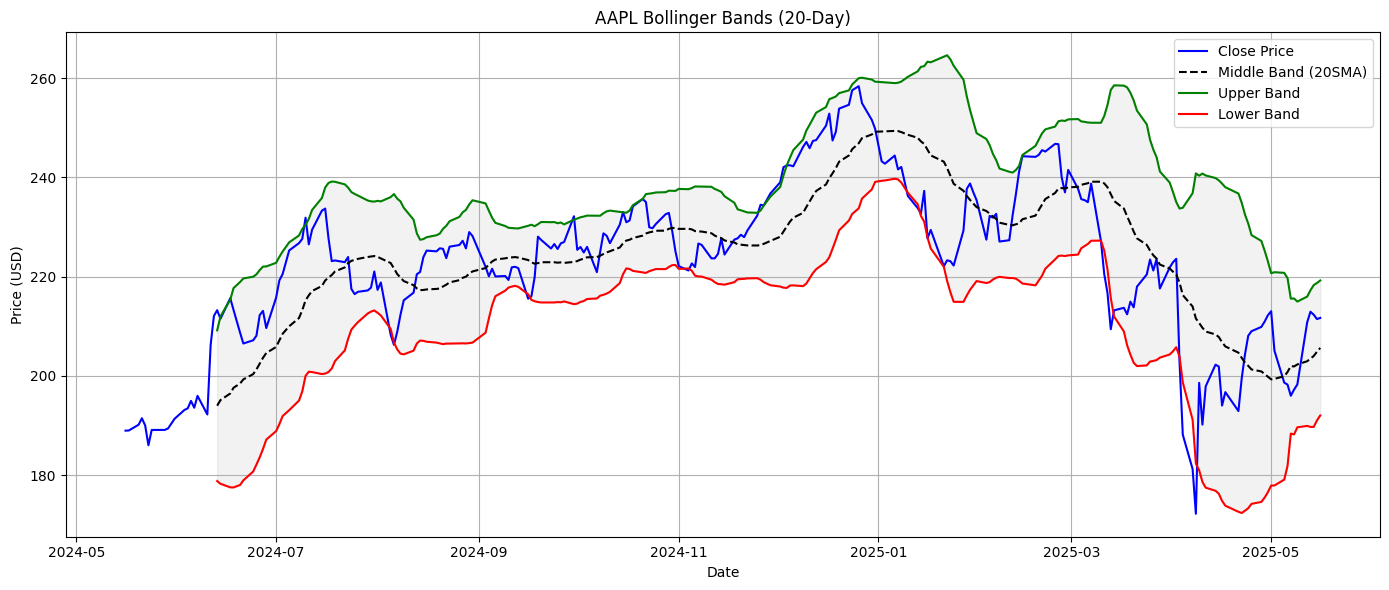

In [26]:
df.reset_index(inplace=True)

# Ensure 'Close' is a 1D Series
if isinstance(df['Close'], pd.DataFrame):
    close = df['Close'].squeeze()
else:
    close = df['Close']

# Calculate Bollinger Bands on the 'close' Series
df['BBM'] = close.rolling(window=20).mean()
rolling_std = close.rolling(window=20).std()
df['BBU'] = df['BBM'] + 2 * rolling_std
df['BBL'] = df['BBM'] - 2 * rolling_std

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], close, label='Close Price', color='blue')
plt.plot(df['Date'], df['BBM'], label='Middle Band (20SMA)', linestyle='--', color='black')
plt.plot(df['Date'], df['BBU'], label='Upper Band', color='green')
plt.plot(df['Date'], df['BBL'], label='Lower Band', color='red')
plt.fill_between(df['Date'], df['BBL'], df['BBU'], color='gray', alpha=0.1)

# Labels and styling
plt.title("AAPL Bollinger Bands (20-Day)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


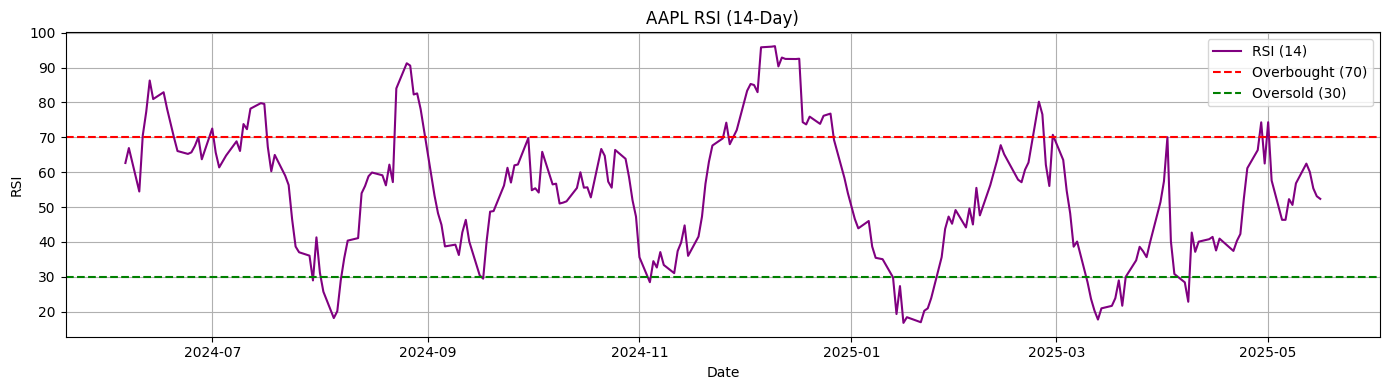

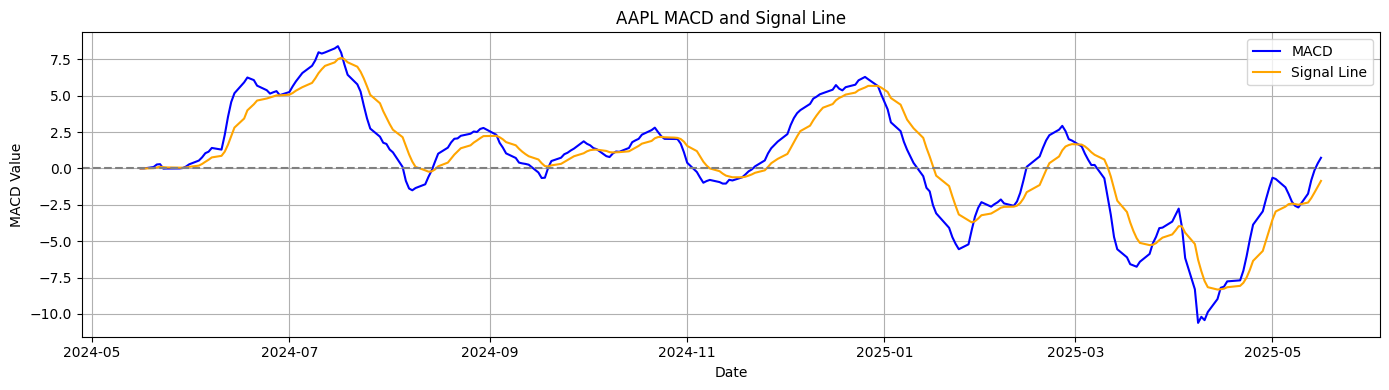

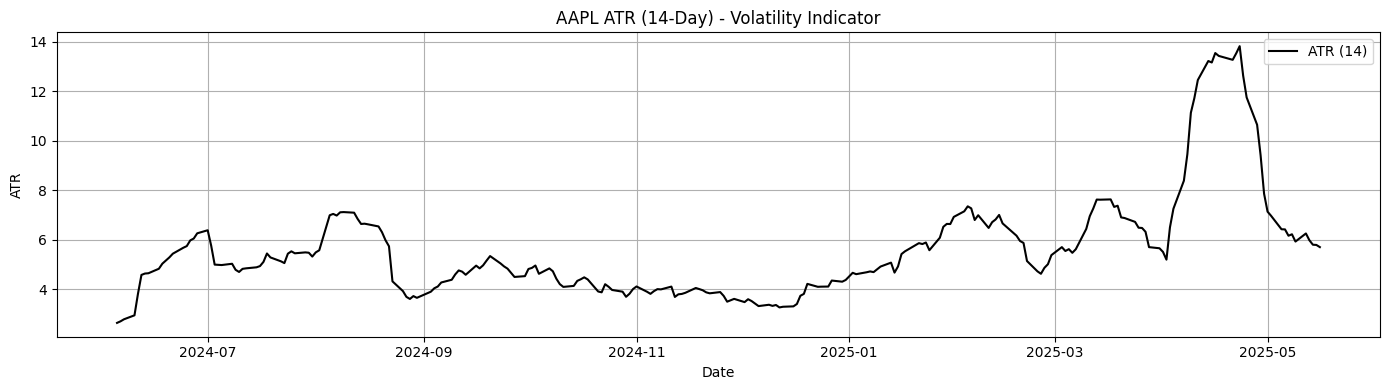

In [27]:
# --- RSI (14-day) ---
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# --- MACD (12/26 EMA) and Signal (9 EMA of MACD) ---
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# --- ATR (14-day Average True Range) ---
df['H-L'] = df['High'] - df['Low']
df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['ATR_14'] = df['TR'].rolling(window=14).mean()

# --- Plot 1: RSI ---
plt.figure(figsize=(14, 4))
plt.plot(df['Date'], df['RSI_14'], label='RSI (14)', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('AAPL RSI (14-Day)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: MACD ---
plt.figure(figsize=(14, 4))
plt.plot(df['Date'], df['MACD'], label='MACD', color='blue')
plt.plot(df['Date'], df['MACD_signal'], label='Signal Line', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title('AAPL MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 3: ATR ---
plt.figure(figsize=(14, 4))
plt.plot(df['Date'], df['ATR_14'], label='ATR (14)', color='black')
plt.title('AAPL ATR (14-Day) - Volatility Indicator')
plt.xlabel('Date')
plt.ylabel('ATR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


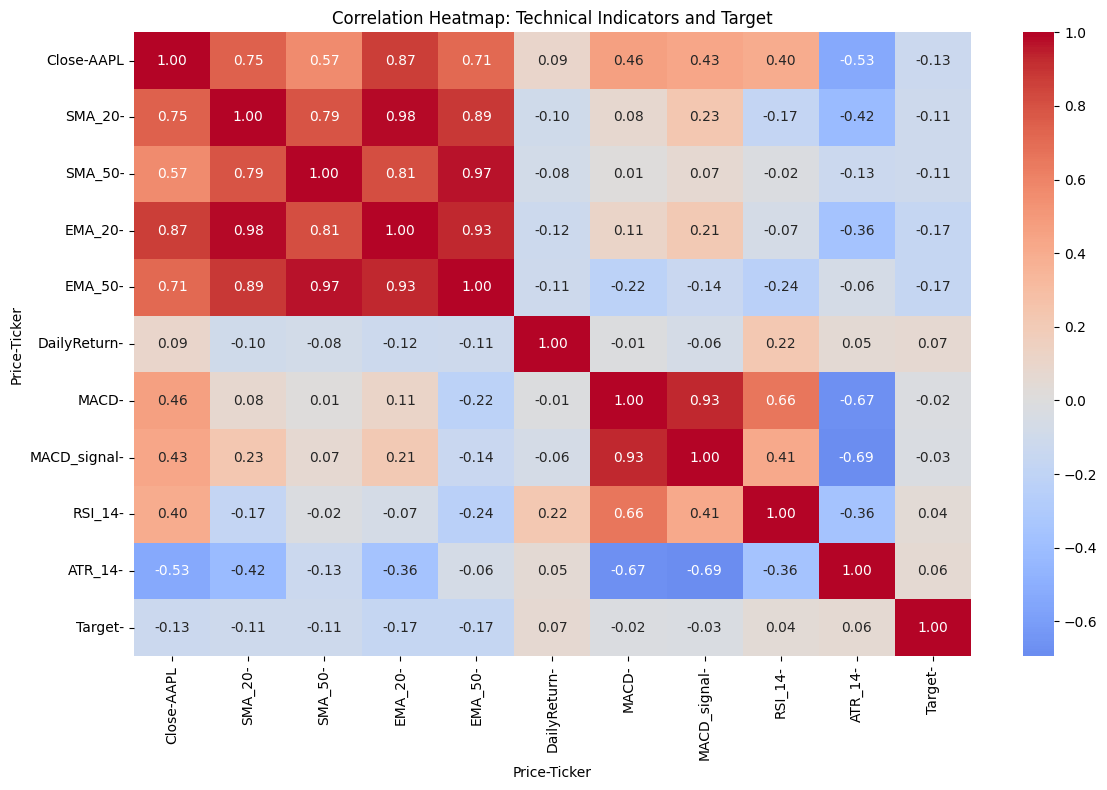

In [32]:
import seaborn as sns

# Step 1: Download AAPL data
df = yf.download("AAPL", period="1y", interval="1d").reset_index()

# --- Ensure 'Close', 'High', 'Low' are Series, not nested DataFrames ---
close = df['Close'].squeeze()
high = df['High'].squeeze()
low = df['Low'].squeeze()

# Step 2: Feature Engineering

# Moving Averages
df['SMA_20'] = close.rolling(window=20).mean()
df['SMA_50'] = close.rolling(window=50).mean()
df['EMA_20'] = close.ewm(span=20, adjust=False).mean()
df['EMA_50'] = close.ewm(span=50, adjust=False).mean()

# Daily Return
df['DailyReturn'] = close.pct_change() * 100

# MACD and Signal Line
ema_12 = close.ewm(span=12, adjust=False).mean()
ema_26 = close.ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# RSI (14)
delta = close.diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# ATR (14)
df['H-L'] = high - low
df['H-PC'] = abs(high - close.shift(1))
df['L-PC'] = abs(low - close.shift(1))
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['ATR_14'] = df['TR'].rolling(window=14).mean()

# Target
df['NextClose'] = close.shift(-1)
df['Target'] = (df['NextClose'] > close).astype(int)

# Step 3: Correlation Matrix
features = [
    'Close', 'SMA_20', 'SMA_50', 'EMA_20', 'EMA_50',
    'DailyReturn', 'MACD', 'MACD_signal', 'RSI_14', 'ATR_14', 'Target'
]

corr_matrix = df[features].corr()

# Step 4: Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Heatmap: Technical Indicators and Target")
plt.tight_layout()
plt.show()


In [48]:
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ✅ Step 1: Download AAPL with known multi-index format
df = yf.download("AAPL", period="3mo", interval="1d", group_by='ticker')

# ✅ Step 2: Flatten MultiIndex columns: ('AAPL', 'Open') → 'Open'
df.columns = df.columns.droplevel(0)  # Drops 'AAPL' and keeps 'Open', 'High', etc.

# ✅ Step 3: Reset index to get 'Date' column
df.reset_index(inplace=True)

# ✅ Step 4: Drop missing data
df = df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])

# ✅ Step 5: Plot with Plotly
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    row_heights=[0.7, 0.3],
    vertical_spacing=0.03,
    subplot_titles=["AAPL Candlestick Chart", "Volume"]
)

# Candlestick chart
fig.add_trace(
    go.Candlestick(
        x=df['Date'],
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name="Price"
    ),
    row=1, col=1
)

# Volume chart
fig.add_trace(
    go.Bar(
        x=df['Date'],
        y=df['Volume'],
        name="Volume",
        marker_color='lightgray'
    ),
    row=2, col=1
)

# Layout
fig.update_layout(
    height=700,
    title="AAPL Candlestick Chart with Volume (Interactive)",
    xaxis_rangeslider_visible=False,
    showlegend=False,
    template="plotly_white"
)

fig.show()


[*********************100%***********************]  1 of 1 completed


**4. Data Preprocessing**

### Data Preparation Steps Before Feeding to Machine Learning Models

**1. Feature/Target Split:**  
We separate the dataset into a feature matrix `X` and a target vector `y`. The target is the `Target` column we created earlier. We drop any columns that are not suitable as inputs to the model (e.g., `NextClose`, or the raw `Adj Close` if it's present). We typically include all engineered features, and possibly original OHLCV columns (`Open`, `High`, `Low`, `Close`, `Volume`) as features.

**2. Train-Test Split (Time Series Split):**  
We split the data based on time, using the first 80% of data for training and the last 20% for testing. This simulates training on past data and testing on future unseen data. Important: we do **not shuffle** the data in time series problems.

**3. Handling Missing Values:**  
After feature engineering, rows with `NaN` values have already been dropped. At this stage, there should be **no missing values** in the feature matrix or target vector.

**4. Feature Scaling:**  
Many machine learning models, especially those based on distance or gradient descent (like Logistic Regression and MLP), benefit from standardized features (zero mean and unit variance).  
We use `StandardScaler`:
- Fit the scaler **only on the training set** to avoid data leakage.
- Then apply the same scaling to the test set.  
Tree-based models like Random Forest or XGBoost are less sensitive to feature scaling, but scaling ensures consistency and doesn’t harm performance.


In [50]:
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Download and prepare AAPL data
df = yf.download("AAPL", period="1y", interval="1d", group_by='ticker')
df.columns = df.columns.droplevel(0)  # Drop 'AAPL' level → get OHLCV columns
df.reset_index(inplace=True)

# Step 2: Feature engineering (simple example)
df['DailyReturn'] = df['Close'].pct_change() * 100
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['NextClose'] = df['Close'].shift(-1)
df['Target'] = (df['NextClose'] > df['Close']).astype(int)

# Step 3: Drop rows with NaN after feature engineering
df.dropna(inplace=True)

# Step 4: Feature/target split
X = df[['Open', 'High', 'Low', 'Close', 'Volume', 'DailyReturn', 'SMA_20', 'EMA_20']]
y = df['Target']

# Step 5: Time-based train-test split (80% train, 20% test)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Step 6: Feature Scaling
scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to test data
X_test_scaled = scaler.transform(X_test)

# Step 7: Output the final shape
print("Train shape:", X_train_scaled.shape)
print("Test shape :", X_test_scaled.shape)


[*********************100%***********************]  1 of 1 completed

Train shape: (184, 8)
Test shape : (47, 8)


**5. Model Building and Evaluation**


### Classification Models and Evaluation Metrics

We will build and evaluate several classification models to predict the **Target** (i.e., whether the next day’s price goes up or down):

**Models to Use:**
- **Logistic Regression**: A simple linear classifier to serve as a baseline.
- **Random Forest**: An ensemble of decision trees, useful for capturing non-linear relationships and feature interactions.
- **XGBoost (Extreme Gradient Boosting)**: A powerful gradient-boosted tree model known for excellent performance on structured data and competitions.
- **MLPClassifier (Neural Network)**: A feed-forward Multi-Layer Perceptron classifier that can model complex, non-linear relationships.

**Evaluation Strategy:**
Each model will be:
1. Trained on the training set.
2. Used to predict on the test set.
3. Evaluated using the following metrics:

**Evaluation Metrics:**
- **Accuracy**:  
  Overall fraction of correct predictions.

- **Precision**:  
  $ \text{Precision} = \frac{TP}{TP + FP} $  
  Measures the fraction of predicted "Up" days that were actually up.

- **Recall**:  
  $ \text{Recall} = \frac{TP}{TP + FN} $  
  Measures the fraction of actual "Up" days that were correctly predicted.

- **F1 Score**:  
  Harmonic mean of precision and recall. Balances both metrics.

- **ROC-AUC (Receiver Operating Characteristic - Area Under Curve)**:  
  Indicates how well the model distinguishes between classes based on probability scores.

- **Confusion Matrix**:  
  A 2x2 table showing:  
  [[True Negatives, False Positives],  
   [False Negatives, True Positives]]

- **Classification Report**:  
  A detailed summary including precision, recall, F1-score, and support for each class from scikit-learn.

We will also **print and/or plot** these metrics for visual comparison across models.


[*********************100%***********************]  1 of 1 completed



📊 Model: Logistic Regression
Accuracy       : 0.5957
Precision      : 0.5870
Recall         : 1.0000
F1 Score       : 0.7397
ROC-AUC        : 0.6019
Confusion Matrix:
 [[ 1 19]
 [ 0 27]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.05      0.10        20
           1       0.59      1.00      0.74        27

    accuracy                           0.60        47
   macro avg       0.79      0.53      0.42        47
weighted avg       0.76      0.60      0.47        47


📊 Model: Random Forest
Accuracy       : 0.5957
Precision      : 0.6053
Recall         : 0.8519
F1 Score       : 0.7077
ROC-AUC        : 0.6296
Confusion Matrix:
 [[ 5 15]
 [ 4 23]]

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.25      0.34        20
           1       0.61      0.85      0.71        27

    accuracy                           0.60        47
   macro avg       0.58      0.55  

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[19:48:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





📊 Model: XGBoost
Accuracy       : 0.5957
Precision      : 0.6000
Recall         : 0.8889
F1 Score       : 0.7164
ROC-AUC        : 0.6019
Confusion Matrix:
 [[ 4 16]
 [ 3 24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.20      0.30        20
           1       0.60      0.89      0.72        27

    accuracy                           0.60        47
   macro avg       0.59      0.54      0.51        47
weighted avg       0.59      0.60      0.54        47



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.




📊 Model: MLPClassifier
Accuracy       : 0.6383
Precision      : 0.6316
Recall         : 0.8889
F1 Score       : 0.7385
ROC-AUC        : 0.6704
Confusion Matrix:
 [[ 6 14]
 [ 3 24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.30      0.41        20
           1       0.63      0.89      0.74        27

    accuracy                           0.64        47
   macro avg       0.65      0.59      0.58        47
weighted avg       0.65      0.64      0.60        47



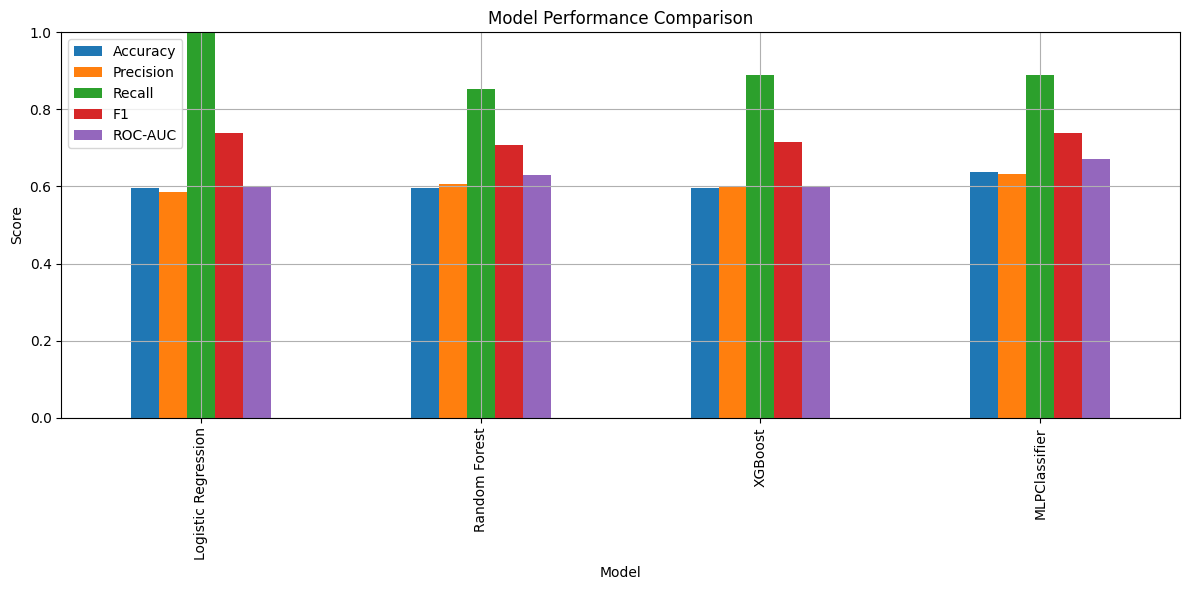

In [51]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Data Loading & Feature Engineering ---
df = yf.download("AAPL", period="1y", interval="1d", group_by='ticker')
df.columns = df.columns.droplevel(0)
df.reset_index(inplace=True)

# Indicators
df['DailyReturn'] = df['Close'].pct_change() * 100
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['NextClose'] = df['Close'].shift(-1)
df['Target'] = (df['NextClose'] > df['Close']).astype(int)
df.dropna(inplace=True)

# --- Step 2: Feature/Target Split ---
X = df[['Open', 'High', 'Low', 'Close', 'Volume', 'DailyReturn', 'SMA_20', 'EMA_20']]
y = df['Target']

# --- Step 3: Time-based Train/Test Split ---
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# --- Step 4: Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Step 5: Define Models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

# --- Step 6: Train, Predict, Evaluate ---
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else y_pred

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n📊 Model: {name}")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision      : {prec:.4f}")
    print(f"Recall         : {rec:.4f}")
    print(f"F1 Score       : {f1:.4f}")
    print(f"ROC-AUC        : {roc:.4f}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    results.append([name, acc, prec, rec, f1, roc])

# --- Step 7: Summary Comparison Plot ---
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'])
results_df.set_index('Model').plot(kind='bar', figsize=(12, 6), title="Model Performance Comparison", grid=True)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


**6. Model Explainability**

### Model Interpretability Techniques

Understanding and trusting model predictions is especially important in finance. We will use two complementary approaches:

**1. Feature Importance (Tree-Based Models)**  
- **What it Shows:** Relative importance of each feature based on how much it reduces impurity (Gini or information gain for Random Forest; gain for XGBoost).  
- **Why It Matters:** Identifies which variables the model relies on most across the entire dataset.  
- **Next Steps:** Extract feature importance from the trained Random Forest and XGBoost models, then plot the **top 10** most important features for each.

**2. SHAP (SHapley Additive ExPlanations)**  
- **What it Shows:** A unified, game-theoretic measure of each feature’s contribution to individual predictions.  
- **Why It Matters:**  
  - **Global Insight:** SHAP summary plots reveal how features push predictions up or down across all test samples.  
  - **Local Insight:** SHAP force or waterfall plots explain single predictions in detail.  


These interpretability tools together help ensure that our models are not only accurate but also transparent and actionable.```


In [52]:
!pip install shap xgboost --quiet

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[19:52:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


<ipython-input-53-63d0959e6f9e>:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




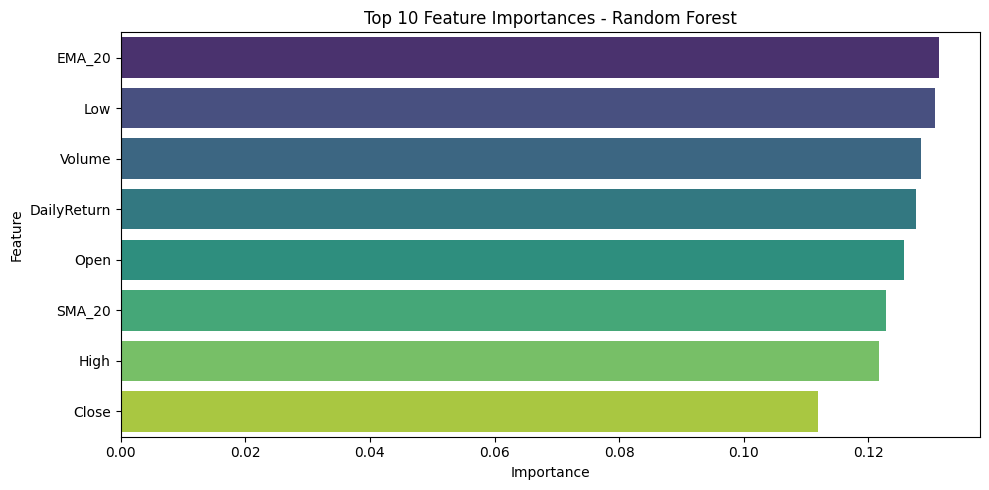

<ipython-input-53-63d0959e6f9e>:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




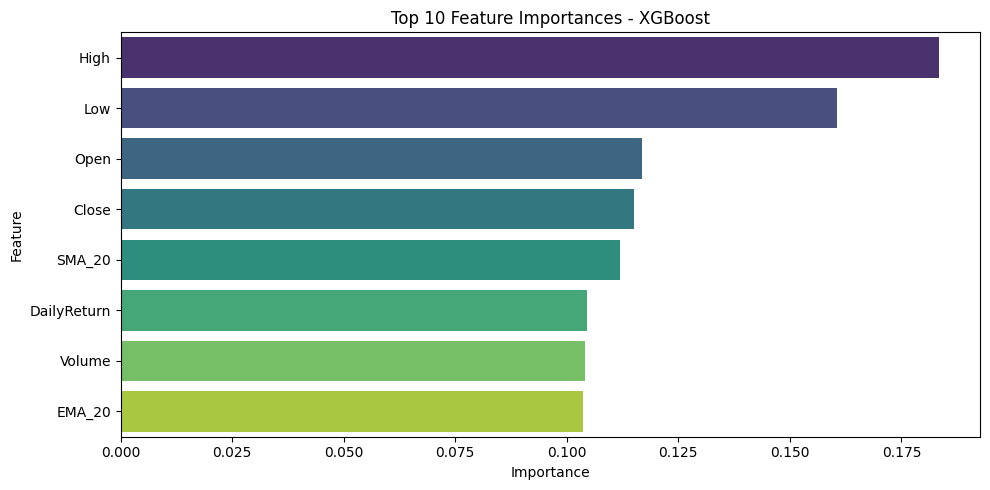

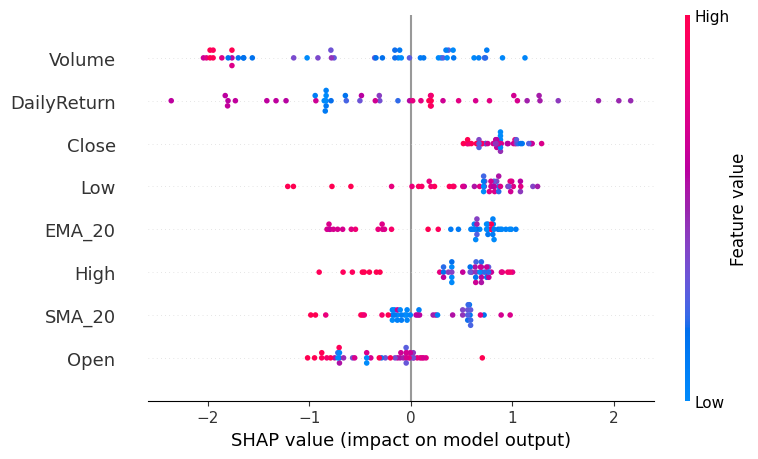

In [53]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 1. Load and Prepare Data
df = yf.download("AAPL", period="1y", interval="1d", group_by='ticker')
df.columns = df.columns.droplevel(0)
df.reset_index(inplace=True)

# Feature Engineering
df['DailyReturn'] = df['Close'].pct_change() * 100
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['NextClose'] = df['Close'].shift(-1)
df['Target'] = (df['NextClose'] > df['Close']).astype(int)
df.dropna(inplace=True)

# Features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'DailyReturn', 'SMA_20', 'EMA_20']
X = df[features]
y = df['Target']

# Time-based train/test split
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Train Random Forest and XGBoost
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

# 3. Feature Importances (Random Forest and XGBoost)
def plot_feature_importance(importances, feature_names, model_name):
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(10)

    plt.figure(figsize=(10, 5))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title(f"Top 10 Feature Importances - {model_name}")
    plt.tight_layout()
    plt.show()

plot_feature_importance(rf_model.feature_importances_, features, "Random Forest")
plot_feature_importance(xgb_model.feature_importances_, features, "XGBoost")

# 4. SHAP Explanation (XGBoost only)
explainer = shap.Explainer(xgb_model, X_train_scaled, feature_names=features)
shap_values = explainer(X_test_scaled)

# Summary plot (global importance + direction)
shap.summary_plot(shap_values, features=X_test_scaled, feature_names=features)

**8. Simple Trading Strategy Backtest**

**Data Preparation:**

We collect 1 year of AAPL stock data and engineer features such as:
- Daily return
- 20-day Simple Moving Average (SMA)
- 20-day Exponential Moving Average (EMA)
- A binary target: 1 if the next day's close is higher than today, otherwise 0
- The actual next-day return (used to simulate strategy performance)

The dataset is split by time: the first 80% is used for training, and the last 20% for testing. Features are standardized using StandardScaler to ensure proper input for the neural network.

**Model Training:**

A Multi-Layer Perceptron (MLP) is trained to classify whether the next day will be an "up" day. The model outputs binary signals for the test set:
- Signal = 1: predict price increase → we simulate a buy
- Signal = 0: predict no increase → we stay in cash

**Strategy Logic:**

The strategy simulates buying at the close of any day when the model predicts an increase (Signal = 1) and selling at the close the next day. If the model predicts a decline (Signal = 0), we do nothing. This is compared to a buy-and-hold strategy that stays invested throughout.

**Evaluation:**

We calculate cumulative returns for both strategies:
- The model-based strategy grows only on selected trade days
- Buy-and-hold grows continuously

A return curve is plotted to compare their performance. This highlights whether the model offers meaningful predictive value in a practical trading context.

[*********************100%***********************]  1 of 1 completed
<ipython-input-54-7799cd9db1f9>:18: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



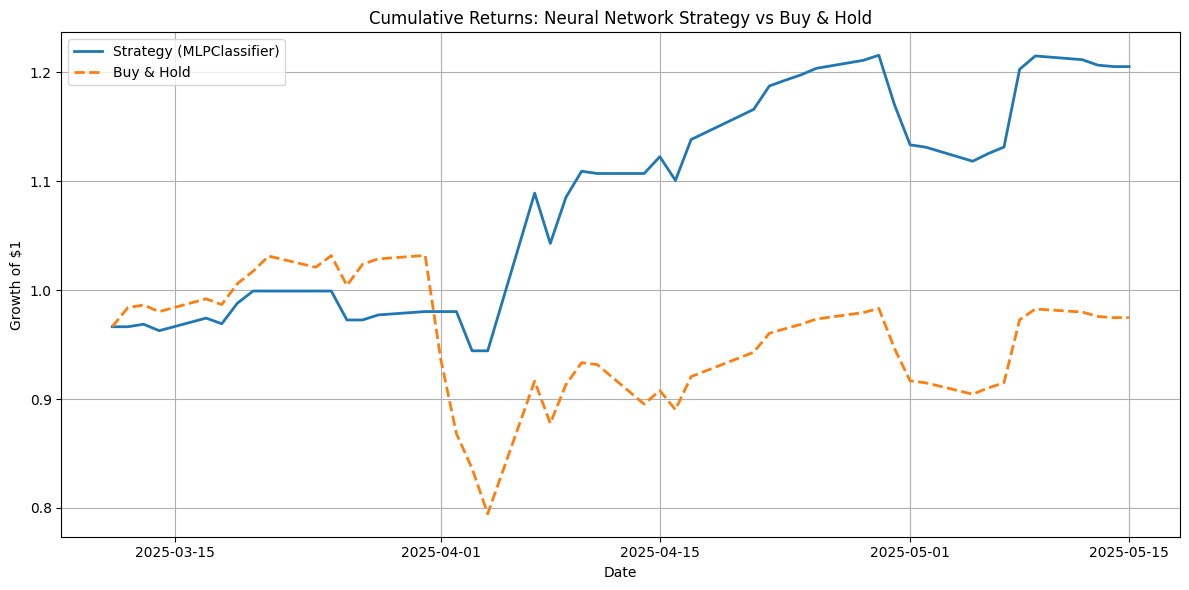

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Step 1: Download AAPL data
df = yf.download("AAPL", period="1y", interval="1d", group_by='ticker')
df.columns = df.columns.droplevel(0)
df.reset_index(inplace=True)

# Step 2: Feature Engineering
df['DailyReturn'] = df['Close'].pct_change() * 100
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['NextClose'] = df['Close'].shift(-1)
df['Target'] = (df['NextClose'] > df['Close']).astype(int)
df['NextReturn'] = df['NextClose'].pct_change().shift(-1) * 100
df.dropna(inplace=True)

# Step 3: Define Features and Target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'DailyReturn', 'SMA_20', 'EMA_20']
X = df[features]
y = df['Target']

# Step 4: Time-based Train/Test Split
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
test_df = df.iloc[split_index:].copy()

# Step 5: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train Neural Network (MLPClassifier)
model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
model.fit(X_train_scaled, y_train)

# Step 7: Predict & Create Trading Signals
test_df['Signal'] = model.predict(X_test_scaled)

# Step 8: Backtest Strategy
test_df['StrategyReturn'] = test_df['Signal'] * test_df['NextReturn'] / 100
test_df['BuyHoldReturn'] = test_df['NextReturn'] / 100

test_df['CumulativeStrategy'] = (1 + test_df['StrategyReturn']).cumprod()
test_df['CumulativeBuyHold'] = (1 + test_df['BuyHoldReturn']).cumprod()

# Step 9: Plot Results
plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'], test_df['CumulativeStrategy'], label='Strategy (MLPClassifier)', linewidth=2)
plt.plot(test_df['Date'], test_df['CumulativeBuyHold'], label='Buy & Hold', linestyle='--', linewidth=2)
plt.title('Cumulative Returns: Neural Network Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Conclusion**

This project demonstrated the end-to-end development of a machine learning-based stock prediction and trading strategy using AAPL's historical data. Beginning with data collection and feature engineering, we built predictive models—including a Neural Network (MLPClassifier)—to forecast whether the stock price would increase the next day. Technical indicators such as moving averages and daily returns were used to enhance the model's input features.

We implemented a time-aware train-test split to preserve temporal integrity and applied proper feature scaling to prepare the data for modeling. Multiple classification models were trained and evaluated using standard performance metrics such as accuracy, precision, recall, F1 score, and ROC-AUC. Model interpretability was addressed through feature importance analysis and SHAP value visualization to ensure transparency and trust in the decision-making process.

To translate model predictions into actionable outcomes, we designed a simple one-day trading strategy: buying the stock at the close of a day if an increase was predicted, and selling it the next day. This strategy was backtested against a buy-and-hold benchmark, and cumulative returns were compared to assess real-world profitability.

Overall, the project showcased how machine learning can be applied to financial forecasting, not just in theory but through practical strategy development and evaluation. It also emphasized the importance of data integrity, proper evaluation, interpretability, and the critical step of assessing financial impact beyond model accuracy.







